In [ ]:
import numpy as np
import glob as glob
import pprint
### Use the Glob Glob file slicing to get all the info from the file.

files = sorted(glob.glob('*fits'))

file_distance = []


### This Dummy Dictionary Stores information relating 
### GRAIN/D2G/MASS with distance and filename. 
dummy_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}    
### Opens the file
with open('distance_output.file') as f:
    ### Reads the file
    distance = f.readlines()
    
for i in range(int(len(distance))):
    if i % 2 == 0:
        file_name = distance[i].strip()
        au = distance[i+1].strip()   

        splitsies = file_name.split('-')
        
        dummy_dict['Grain'].append(splitsies[0].replace('GRAIN',''))
        dummy_dict['D2G'].append(splitsies[1].replace('D2G',''))
        dummy_dict['Mass'].append(splitsies[2].replace('MASS',''))
        dummy_dict['Planet Distance'].append(au)
        dummy_dict['Full File Name'].append(file_name)
###
        
        
### This is the real dictionary maker. 
### By real I mean it slices out all information for a file
### and stores it with the file name. 
file_dict = {
    "Wavelength" : [],
    "Grain" : [],
    "D2G" : [],
    "Mass" : [],
    "Planet Distance" : [],
    "Full File Name" : []
}    

for i in range(len(files)):
    splitsies = files[i].split('-')
    file_dict['Wavelength'].append(splitsies[0])
    file_dict['Grain'].append(splitsies[1].replace('GRAIN',''))
    file_dict['D2G'].append(splitsies[2].replace('D2G',''))
    file_dict['Mass'].append(splitsies[3].replace('MASS','').replace('.fits',''))
    file_dict['Planet Distance'].append(None)
    file_dict['Full File Name'].append(files[i])
###
    
    
### This takaes the dictionary of distances and associates it
### With the dictionary of file names 
for j in range(len(dummy_dict['D2G'])):
    for i in range(len(file_dict['D2G'])):
        ### Gets the pairs of file_name and distance   
        if file_dict['Grain'][i] == dummy_dict['Grain'][j] and file_dict['D2G'][i] == dummy_dict['D2G'][j]:
            file_dict['Planet Distance'][i] = dummy_dict['Planet Distance'][j]
            


In [ ]:
import os
import glob
import numpy as np
import astropy.io as astr
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from matplotlib.ticker import AutoMinorLocator

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    
    
    return radialprofile 

def plot_fits(file_dict, verbose = False, selection = None, logSpace=True, radiusScale=False,lBoundary=5, uBoundary=150):
    """
    INPUTS:
    --------
     
    
    
    OUTPUTS:
    --------
    
    
    """
    if selection == None:
        print("What in the fuck are you doing? \nThere aint no dictionary iterating.")
        return
    
    print('Log Space? {}'.format(logSpace))
    print('Scaled with Radius? {}'.format(radiusScale))    
    
    plt.figure()
    ### Extracting relevant info from fits file with astropy.fits
    wavelength = file_dict['Wavelength'][selection]
    grain = file_dict['Grain'][selection]
    d2g = file_dict['D2G'][selection]
    mass = file_dict['Mass'][selection]
    filename = file_dict['Full File Name'][selection]
    planet_locale = file_dict['Planet Distance'][selection]
    
    hdul = get_pkg_data_filename(filename)
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
        
        ### Need to define the center for the radial profile
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = radial_profile(data, center)
        
        ### This becomes the x-axis
    length = np.arange(profile.shape[0])
        
        ### Cuttomg down profile to Upper and Lower Boundary
    mod_profile = profile[lBoundary:uBoundary]
    normalized_profile = mod_profile/mod_profile.max()
        
    ### This ensures that even when truncated, x-axis is labeled correctly
        ### I have no recollection of what this is intended to do 12-18-2022
        ### Well I have no idea what it is indended to do, but I know what it does
    ### This scales the length array so that it isn't just an array along one dimension
    r_scale = center[0]/profile.shape[0]

    if logSpace == True:
        intensity_profile = np.log(normalized_profile)
            
    else:
        intensity_profile = normalized_profile
        
    if radiusScale == True:
        r_squared = length[lBoundary:uBoundary] ** 2
        intensity_profile = normalized_profile * r_squared
    
    title = "Grain Size : {grain} // D2G : {d2g}"
    label = title.format(grain = grain, d2g = d2g)
    picture = "{wavelength}-{grain}-{d2g}-{mass}.png"
    picture_name = picture.format(wavelength = wavelength,
                                 grain = grain,
                                 d2g = d2g,
                                 mass = mass)
    
    plt.vlines(float(planet_locale), intensity_profile.min(),intensity_profile.max(),color='r')
    plt.plot(length[lBoundary:uBoundary] * r_scale, intensity_profile,label=label)
    
    plt.title("Normalized Intensity vs Radius (AU) for Wavelength {}".format(wavelength))
    plt.tick_params(which='both', width=2)
    plt.tick_params(which='major', length=7)
    plt.tick_params(which='minor', length=4, color='r')
    plt.grid()
    plt.xlabel('AU')
    plt.ylabel('Normalized Intensity')
    plt.grid(which="minor")
    plt.legend()
    plt.savefig(picture_name)
    if verbose == True: 
        plt.show()

def easy_Gauss(p,x):
    a, mu, sigma = p
    return a * np.exp(- (x - mu) ** 2 / (2. * sigma ** 2))

def error_ez_Gauss(params, x, y, err, fjac=None):
    
    status=0
    
    return[status, (y - easy_Gauss(params, x)) / err]

def test_Gaussian(x, y, params, parinfo = None, err = 1):
    import mpfit.mpfit
    inputs = {'x': x , 'y': y , 'err': err}
    GaussFit = mpfit.mpfit.mpfit(error_ez_Gauss, params, 
                                functkw = inputs,
                                 parinfo = parinfo,
                                quiet=True, ftol=1e-10,
                               xtol=1e-10, gtol=1e-10)
    return GaussFit.params, GaussFit.perror

def ExteriorGapGetter(file_dict, selection = None, plots=False):
    if selection == None:
        print("What in the fuck are you doing? \nThere aint no dictionary iterating.")
        return
    import plonk as plonk
    import matplotlib.pyplot as plt
    import matplotlib.colors as clr
    import numpy as np
    import h5py
    import glob
    
    
    ### Extracting relevant info from fits file with astropy.fits
    wavelength = float(file_dict['Wavelength'][selection])
    grain = float(file_dict['Grain'][selection])
    d2g = float(file_dict['D2G'][selection])
    mass = float(file_dict['Mass'][selection])
    filename = file_dict['Full File Name'][selection]
    planet_locale = float(file_dict['Planet Distance'][selection])
    
    hdul = get_pkg_data_filename(filename)
    image_data = astr.fits.getdata(hdul, ext=0)
    data = image_data[0][0][0][:][:]
       
    center = (data.shape[0]/2,data.shape[1]/2)
    profile = np.log(radial_profile(data, center))
    ### 
    #
    # Need a new index truncation scheme and radius finder 12/20/22
    #
    ###
    trunc_index = 150#np.argmin(np.abs(profile['radius'].to('au').magnitude - 150))
    length = np.arange(profile.shape[0])
    intensity_profile = profile[:trunc_index]
    radius = length[:trunc_index] * center[0]/profile.shape[0] ### I think this might be in AU 
    planet_index = np.argmin(np.abs(radius - (planet_locale + 0.1*planet_locale)))
    
    ### Everything I want to do with the gap bottom and "top"    
    # Finding local exterior max to set as RHS
    # planet_index needs an offset so that the planet location can't be counted as the max
    # I want that bound to be non-inclusive
    new_zero_shift = profile[planet_index+1:].max()
    RHS_index = np.argmin(np.abs(profile - new_zero_shift))
    RHS = radius[RHS_index]
    
    # Finds a local minima: value and AU and depth
    trunc_profile = profile[planet_index:RHS_index]
    gap_bottom_index = np.argmin(trunc_profile)
    gap_bottom_val = trunc_profile[gap_bottom_index]
    gap_bottom_loc = radius[np.argmin(np.abs(profile - gap_bottom_val))]
    gap_depth = new_zero_shift - gap_bottom_val
     
    x = radius
    y = -intensity_profile + new_zero_shift
    
    ### Gaussian Amplitude 
    amp = gap_depth
    ### Gaussian peak at 
    mu = gap_bottom_loc
    ### Estimating sigma assuming that the distance from mu to the edge is 3*sigma
    sigma = (RHS - gap_bottom_loc)/3
    
    params = np.asarray((amp,mu,sigma))
    constraints =[
            #Amp
            {'limited': [0,0], # enforce lower/upper constraint
             'limits':  [0.5*params[0], 1.5*params[0]], # lower/upper constraints
             'fixed': True, # don't let the parameter change
             'value': params[0]}, 
            
            #Mu
            {'limited': [1,1], 
             'limits': [1.0*params[1],  1.5*params[1]], 
             'fixed': False, 
             'value': params[1]},
            
            #Sigm
            {'limited': [0,1], 
             'limits': [0.5*params[2], 1.5*params[2]],          
             'fixed': False,
             'value': params[2]}]
             
             
    delta_planet_gap = gap_bottom_loc - planet_locale
    a, b = test_Gaussian(x,y,params,constraints)

    if plots == True:
        figure, ax = plt.subplots(figsize=(8, 6))
        plt.title('Intensiety Gap Width and Gap Depth')
        plt.plot(radius,intensity_profile)
        plt.hlines(new_zero_shift,radius.min(),radius.max(), color='g')
        plt.vlines(planet_locale,profile.min(),profile.max(), color='black') 
        plt.vlines(gap_bottom_loc, gap_bottom_val, new_zero_shift, color='red')    
    
    
        gauss = easy_Gauss(a, x)
        
        plt.plot(x,-gauss+new_zero_shift, c='r')
        plt.show()


In [ ]:
for i in range(len(files)):
    plot_fits(file_dict,selection=i,)
    print(file_dict['Full File Name'][i])

In [18]:
selection = 2
plots = True
wavelength = float(file_dict['Wavelength'][selection])
grain = file_dict['Grain'][selection]
d2g = file_dict['D2G'][selection]
mass = file_dict['Mass'][selection]
filename = file_dict['Full File Name'][selection]
planet_locale = float(file_dict['Planet Distance'][selection])
hdul = get_pkg_data_filename(filename)
image_data = astr.fits.getdata(hdul, ext=0)
data = image_data[0][0][0][:][:]
        
### Need to define the center for the radial profile
center = (data.shape[0]/2,data.shape[1]/2)

<ipython-input-19-908fe300725b>:17: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


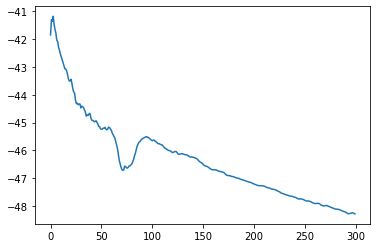

In [19]:
#####
### This one works 12-23-22
phi_array = np.empty((data.shape[0],data.shape[1]))
r_array = np.empty((data.shape[0],data.shape[1]))
y, x = np.indices((data.shape))
calc_x = x - center[0]
calc_y = y - center[1]

phi_array = np.arctan2(calc_y, calc_x) * 180 / np.pi
r_array = np.sqrt((calc_x)**2 + (calc_y)**2)

mask = (phi_array > 20) & (phi_array <= 30)
masked_data = data[mask]
masked_r = r_array[mask].astype(np.int)
tbin = np.bincount(masked_r.ravel(), masked_data.ravel())
nr = np.bincount(masked_r.ravel())
bad_radial_profile = np.log(tbin/nr)
sub_radial_profile = bad_radial_profile[~np.isnan(bad_radial_profile)]
#####
length = np.arange(sub_radial_profile.shape[0])
radius = length * center[0]/sub_radial_profile.shape[0]

plt.plot(radius,sub_radial_profile)

### Have an azimuth sweep to test in BBEdit - 12/24/22

In [ ]:
azimuth_sweep = np.linspace(-180, 180, num=36)
for i in range(36):
    if i == len(azimuth_sweep)-1:
        j = 0
    else:
        j = i + 1
        mask_min = azimuth_sweep[i]
        mask_max = azimuth_sweep[j]
        mask = (phi_array > mask_min) & (phi_array <= mask_max+0.1)      

In [ ]:
### This fitting works
### I need to add loads of NaN protection, but it works 12-26-22

planet_index = np.argmin(np.abs(radius - (planet_locale + 0.1*planet_locale)))
    
    ### Everything I want to do with the gap bottom and "top"    
    # Finding local exterior max to set as RHS
    # planet_index needs an offset so that the planet location can't be counted as the max
    # I want that bound to be non-inclusive
    
### I think all of my errors come down to the RHS_Index returning zero
new_zero_shift = sub_radial_profile[planet_index+1:].max()
RHS_index = np.nanargmin(np.abs(sub_radial_profile - new_zero_shift))
RHS = radius[RHS_index]

    # Finds a local minima: value and AU and depth
trunc_profile = sub_radial_profile[:RHS_index]#[planet_index:RHS_index]
gap_bottom_index = np.nanargmin(trunc_profile)
gap_bottom_val = trunc_profile[gap_bottom_index]
gap_bottom_loc = radius[np.nanargmin(np.abs(sub_radial_profile - gap_bottom_val))]
gap_depth = new_zero_shift - gap_bottom_val

x = radius
y = -sub_radial_profile + new_zero_shift
    
    ### Gaussian Amplitude 
amp = gap_depth
    ### Gaussian peak at 
mu = gap_bottom_loc
    ### Estimating sigma assuming that the distance from mu to the edge is 3*sigma
sigma = (RHS - gap_bottom_loc)/3
    
params = np.asarray((amp,mu,sigma))
constraints =[
            #Amp
            {'limited': [1,1], # enforce lower/upper constraint
             'limits':  [0.5*params[0], 1.5*params[0]], # lower/upper constraints
             'fixed': False, # don't let the parameter change
             'value': params[0]}, 
            
            #Mu
            {'limited': [1,1], 
             'limits': [1.0*params[1],  1.5*params[1]], 
             'fixed': False, 
             'value': params[1]},
            
            #Sigma
            {'limited': [0,1], 
             'limits': [0.5*params[2], 1.5*params[2]],          
             'fixed': False,
             'value': params[2]}]
             
             
a, b = test_Gaussian(x,y,params,constraints)
if plots == True:
    figure, ax = plt.subplots(figsize=(8, 6))
    plt.title('Intensiety Gap Width and Gap Depth')
    plt.plot(radius,sub_radial_profile)
    plt.hlines(new_zero_shift,radius.min(),radius.max(), color='g')
    plt.vlines(gap_bottom_loc, gap_bottom_val, new_zero_shift, color='red')    
    
    
    gauss = easy_Gauss(a, x)
        
    plt.plot(x,-gauss+new_zero_shift, c='r')
    plt.show()

### Possibility of the new gap needing to be deconvolved or something?

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


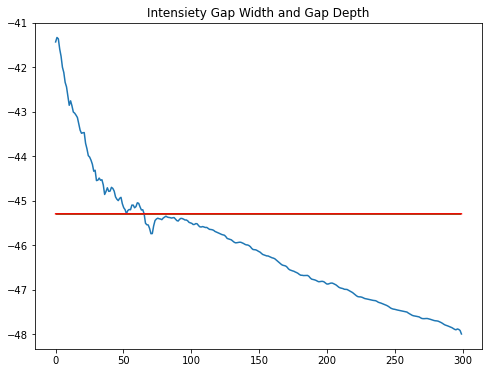

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


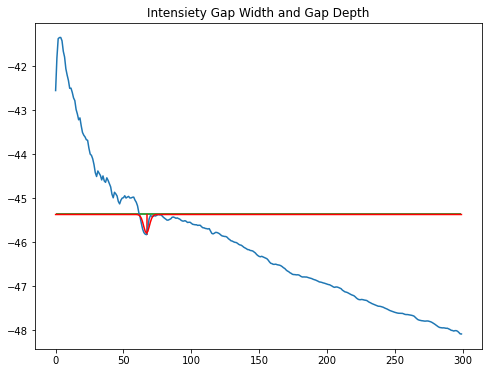

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


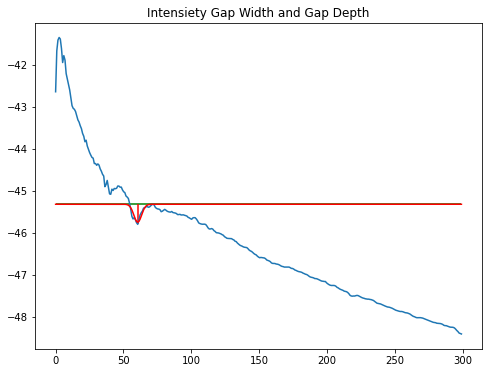

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


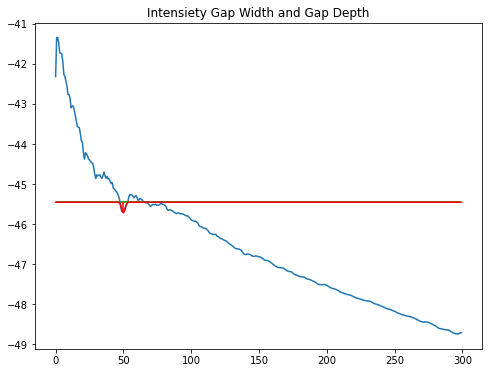

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


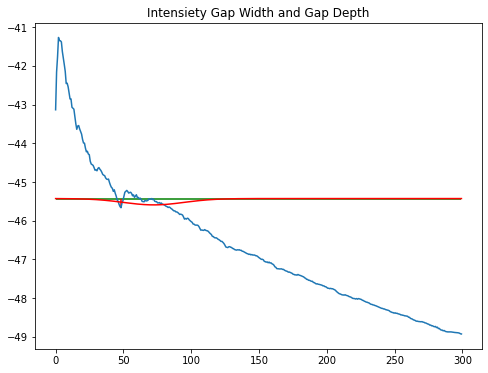

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


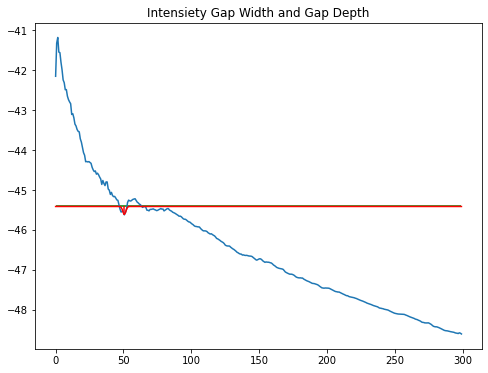

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


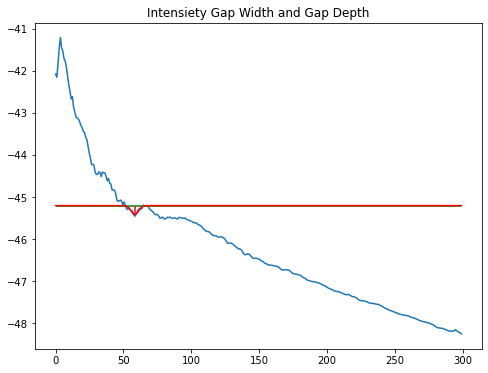

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


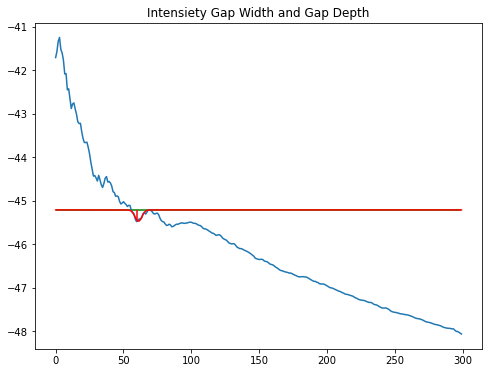

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


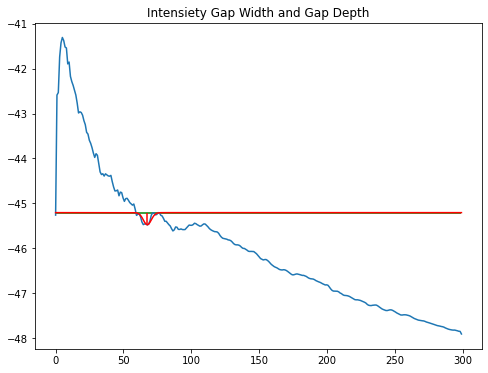

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


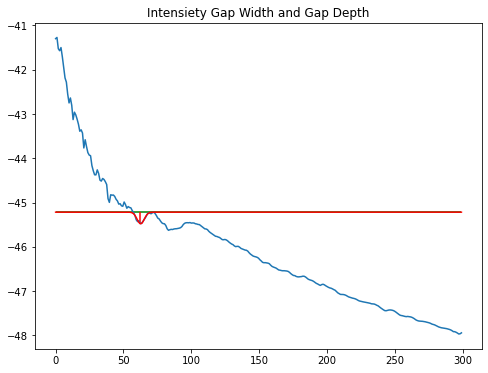

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


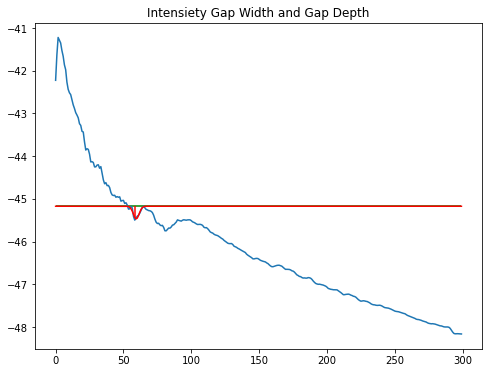

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


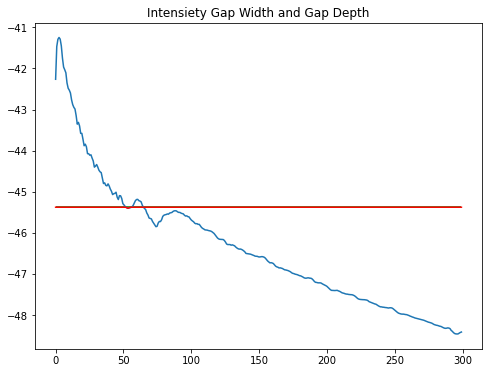

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


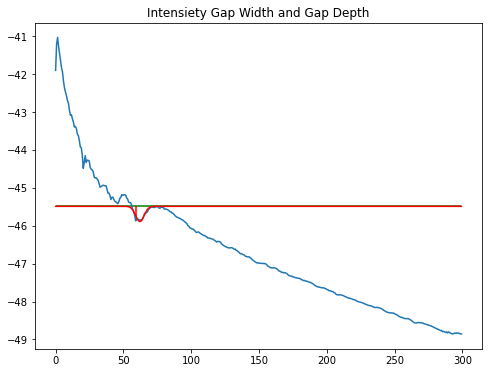

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


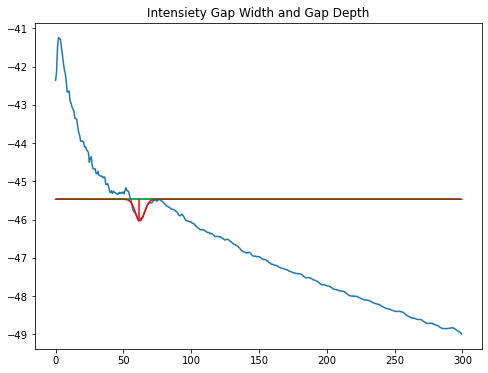

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


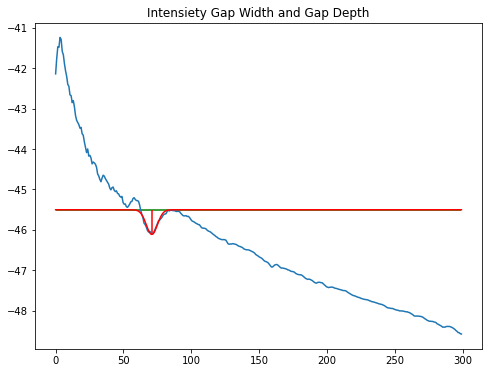

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


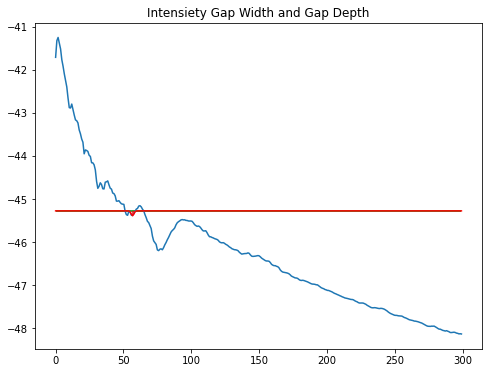

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


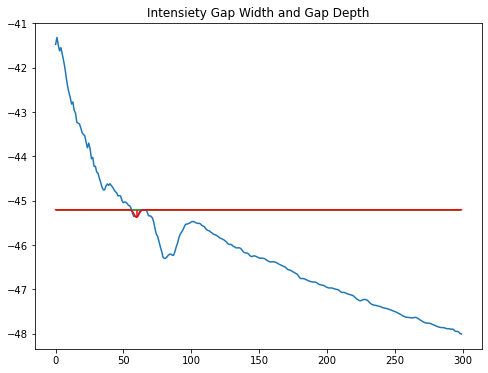

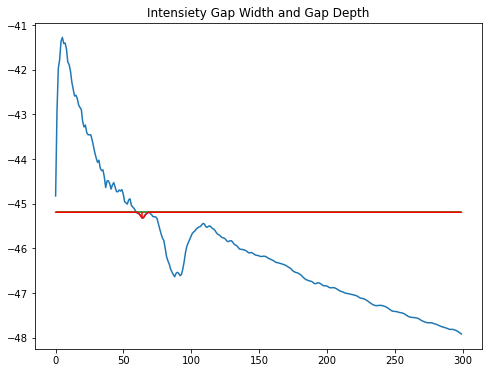

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


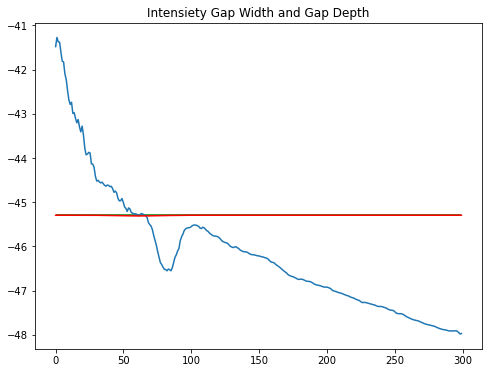

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


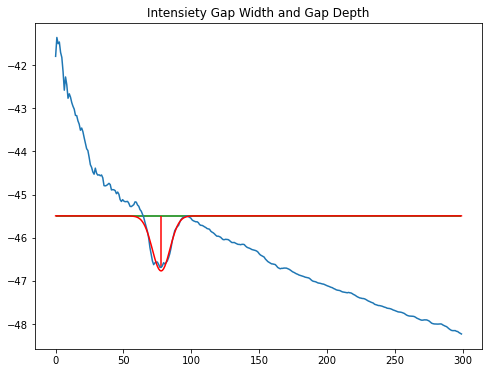

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


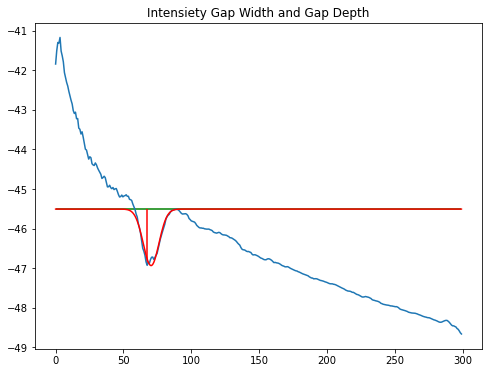

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


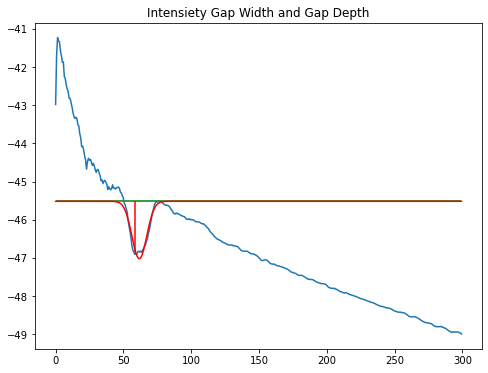

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


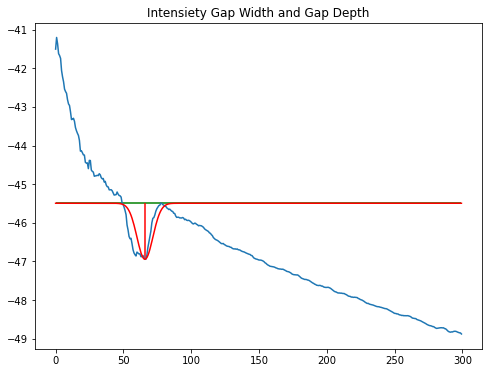

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


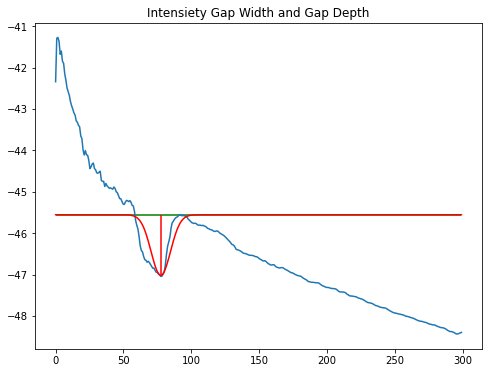

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


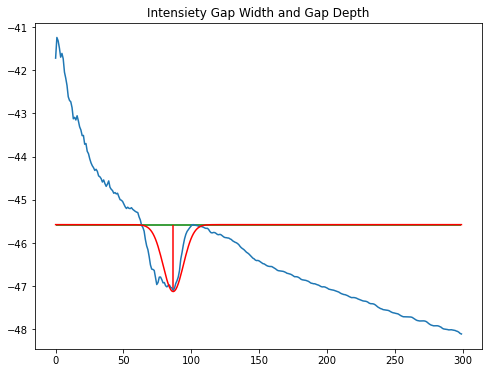

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


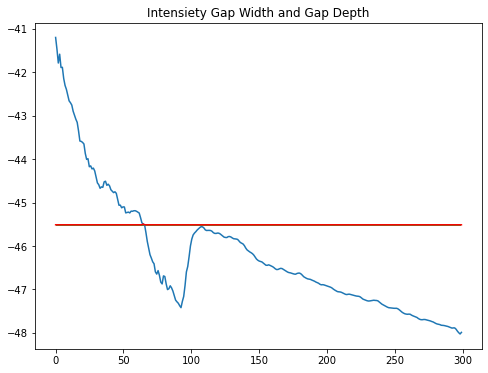

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


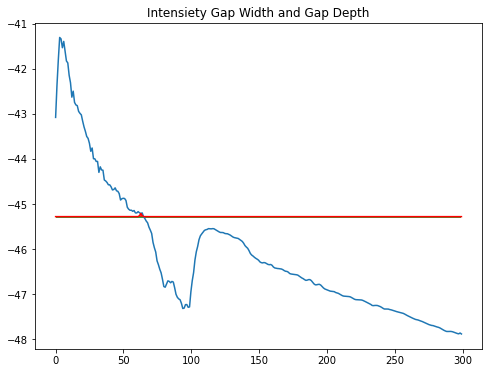

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


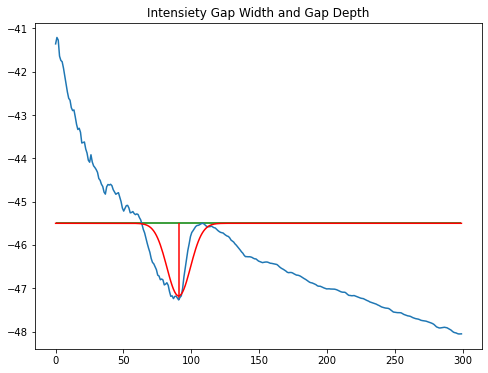

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


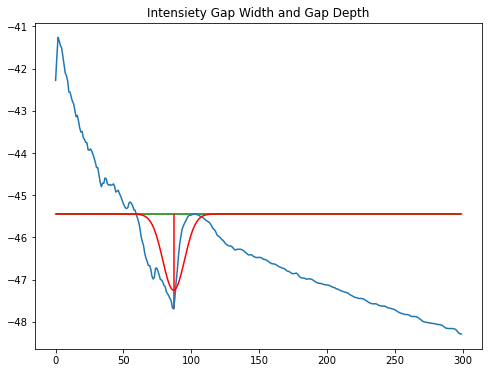

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


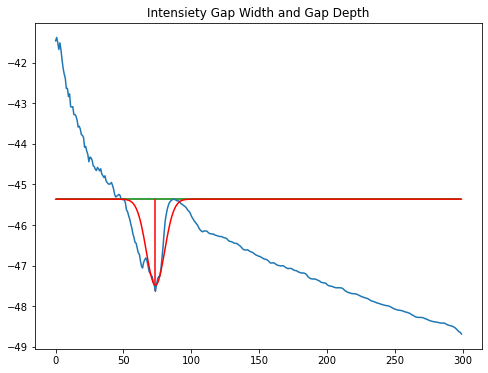

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


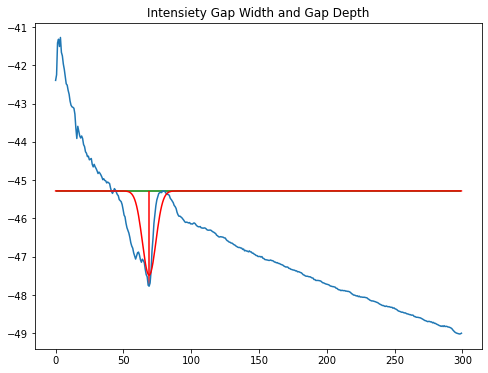

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


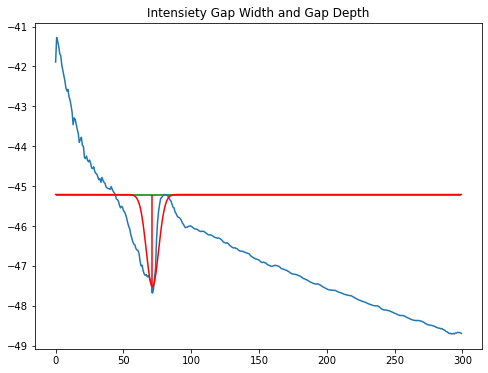

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


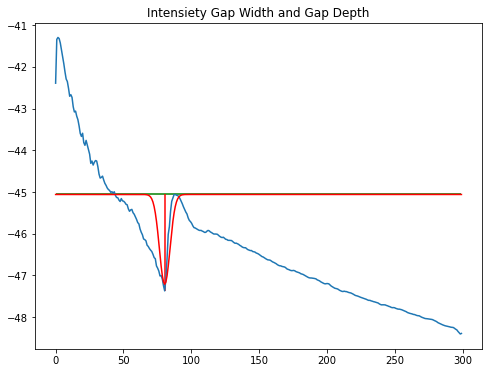

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


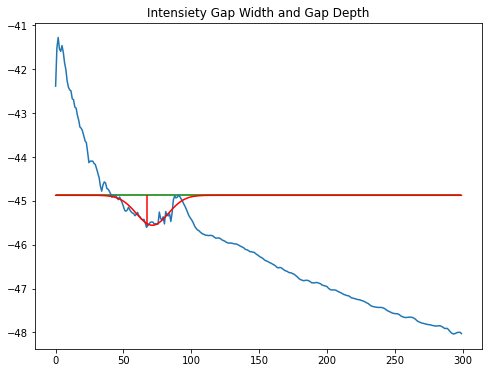

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


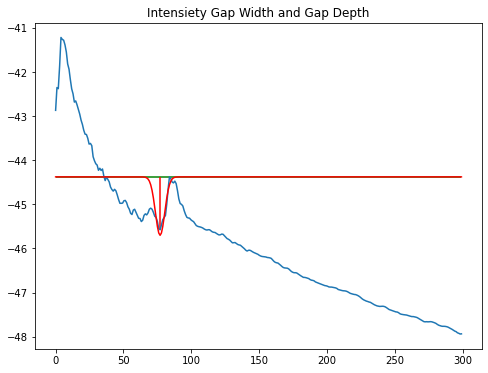

<ipython-input-20-c457a8bbf310>:24: RuntimeWarning: invalid value encountered in true_divide
  bad_radial_profile = np.log(tbin/nr)


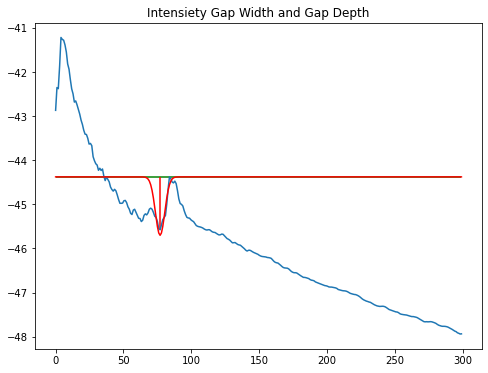

In [20]:

azimuth_sweep = np.linspace(-180, 180, num=36)
for i in range(36):
    if i == len(azimuth_sweep)-1:
        j = 0
    else:
        j = i + 1
        mask_min = azimuth_sweep[i]
        mask_max = azimuth_sweep[j]
        mask = (phi_array > mask_min) & (phi_array <= mask_max+0.1)    	

    phi_array = np.empty((data.shape[0],data.shape[1]))
    r_array = np.empty((data.shape[0],data.shape[1]))
    y, x = np.indices((data.shape))
    calc_x = x - center[0]
    calc_y = y - center[1]
    
    phi_array = np.arctan2(calc_y, calc_x) * 180 / np.pi
    r_array = np.sqrt((calc_x)**2 + (calc_y)**2)
    
    masked_data = data[mask]
    masked_r = r_array[mask].astype(np.int)
    tbin = np.bincount(masked_r.ravel(), masked_data.ravel())
    nr = np.bincount(masked_r.ravel())
    bad_radial_profile = np.log(tbin/nr)
    sub_radial_profile = bad_radial_profile[~np.isnan(bad_radial_profile)]
    #####
    length = np.arange(sub_radial_profile.shape[0])
    radius = length * center[0]/sub_radial_profile.shape[0]
    
    planet_index = np.argmin(np.abs(radius - (planet_locale + 0.1*planet_locale)))
        
### Everything I want to do with the gap bottom and "top"    
# Finding local exterior max to set as RHS
# planet_index needs an offset so that the planet location can't be counted as the max
# I want that bound to be non-inclusive
    
### I think all of my errors come down to the RHS_Index returning zero
    new_zero_shift = sub_radial_profile[planet_index+1:].max()
    RHS_index = np.nanargmin(np.abs(sub_radial_profile - new_zero_shift))
    RHS = radius[RHS_index]
    
        # Finds a local minima: value and AU and depth
    trunc_profile = sub_radial_profile[:RHS_index]#[planet_index:RHS_index]
    gap_bottom_index = np.nanargmin(trunc_profile)
    gap_bottom_val = trunc_profile[gap_bottom_index]
    gap_bottom_loc = radius[np.nanargmin(np.abs(sub_radial_profile - gap_bottom_val))]
    gap_depth = new_zero_shift - gap_bottom_val
    
    x = radius
    y = -sub_radial_profile + new_zero_shift
        
    ### Gaussian Amplitude 
    amp = gap_depth
    ### Gaussian peak at 
    mu = gap_bottom_loc
    ### Estimating sigma assuming that the distance from mu to the edge is 3*sigma
    sigma = (RHS - gap_bottom_loc)/3
        
    params = np.asarray((amp,mu,sigma))
    constraints =[
                #Amp
                {'limited': [1,1], # enforce lower/upper constraint
                 'limits':  [0.5*params[0], 1.5*params[0]], # lower/upper constraints
                 'fixed': False, # don't let the parameter change
                 'value': params[0]}, 
            
                #Mu
                {'limited': [1,1], 
                 'limits': [1.0*params[1],  1.5*params[1]], 
                 'fixed': False, 
                 'value': params[1]},
                
                #Sigma
                {'limited': [0,1], 
                 'limits': [0.5*params[2], 1.5*params[2]],          
                 'fixed': False,
                 'value': params[2]}]
             
            
    a, b = test_Gaussian(x,y,params,constraints)
    if plots == True:
        figure, ax = plt.subplots(figsize=(8, 6))
        plt.title('Intensiety Gap Width and Gap Depth')
        plt.plot(radius,sub_radial_profile)
        plt.hlines(new_zero_shift,radius.min(),radius.max(), color='g')
        plt.vlines(gap_bottom_loc, gap_bottom_val, new_zero_shift, color='red')    
        
        
        gauss = easy_Gauss(a, x)
        
        plt.plot(x,-gauss+new_zero_shift, c='r')
        plt.show()
        
### Breaking this up azimuthally doesn't work as well. 
### I think I can't exactly rely on my planet index to do everything
### Or perhaps more accurately, I can't rely on the [planet_index+1:].max() 
